In [1]:
# Imports

import random
import numpy as np
from sklearn.datasets import load_iris
import pandas as pd
import sklearn.model_selection
from sklearn.preprocessing import StandardScaler

In [2]:
# Declare constants

NUM_INPUT_NODES = 4
NUM_OUTPUT_NODES = 3
NUM_HIDDEN_NODES = 11
NUM_HIDDEN_LAYERS = 1

In [3]:
class Node:
    """Each node has a weight and bias"""
    def __init__(self, num_weights):
        """
        num_weights: the number of nodes in the previous layer
        """
        self.z = 0
        self.activation = 0
        self.weights = [random.uniform(0, 0.01) for _ in range(num_weights)]
        self.bias = random.uniform(0.0, 0.01)

# Consider using a separate class for input node, not necessary
class InputNode:
    def __init__(self):
        self.activation = 0

In [4]:
# activation functions

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def leaky_relu(x, alpha=0.01):
    return max(alpha * x, x)

def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits))  # for numerical stability
    return exp_logits / np.sum(exp_logits, axis=0)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def sigmoid_derivative(x):
    return x * (1 - x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

In [5]:
class MLP:
    "Create a multilayer perceptron"
    def __init__(self, n_in, n_out, n_hidden, hidden_layers):
        self.n_hidden_layers = hidden_layers;
        self.nodes = []
        self.create(n_in, n_out, n_hidden)
        self.gradient = []

    def create(self, n_in, n_out, n_hidden):
        nodes = []
        
        input_layer = [InputNode() for _ in range(n_in)]
        nodes.append(input_layer)
        
        for i in range(self.n_hidden_layers):
            nodes.append([Node(num_weights=n_in) for _ in range(n_hidden)])
            
        output_layer = [Node(num_weights=n_hidden) for _ in range(n_out)]
        nodes.append(output_layer)
        
        self.nodes = nodes

    def forward_pass(self, X_row, y_row):
        # input layer
        for i, input_node in enumerate(self.nodes[0]):
            input_node.activation = X_row[i]

        # input layer to hidden layer
        for L in range(1, self.n_hidden_layers + 1):  # note +1 must be used bc the range is not inclusive of upper
            for node_j in self.nodes[L]:
                node_j.z = sum(node_k.activation * node_j.weights[k] for k, node_k in enumerate(self.nodes[L - 1])) + node_j.bias
                node_j.activation = leaky_relu(node_j.z)

        # calculate z of output layer
        for output_node_j in self.nodes[-1]:
            output_node_j.z = sum(node_k.activation * output_node_j.weights[k] for k, node_k in enumerate(self.nodes[-2])) + output_node_j.bias

        # apply softmax to output layer activations as a vector
        softmax_output = softmax([output_node.z for output_node in self.nodes[-1]])
        
        #update activations of output layer
        for j, output_node_j in enumerate(self.nodes[-1]):
            output_node_j.activation = softmax_output[j]

        output = [node.activation for node in mlp.nodes[-1]]
        error = np.mean(abs(output - y_row))
        return output, error

    def compute_gradient(self, y):
        ohw = []  # contains partial derivative of cost w respect to weights btwn output and hidden
        ohb = []  # contains partial derivative of cost w respect to biases btwn output and hidden
        hiw = []  # contains partial derivative of cost w respect to weights btwn hidden and input
        hib = []  # contains partial derivative of cost w respect to biases btwn hidden and input

        # weights btwn output and hidden 
        for j, output_node_j in enumerate(self.nodes[-1]):
            for k, weight_jk in enumerate(output_node_j.weights):
                a_k = self.nodes[-2][k].activation
                z_j = output_node_j.z
                a_j = output_node_j.activation
                partial = a_k * leaky_relu_derivative(z_j) * 2 * (a_j - y[j])
                ohw.append(partial)
                
        # biases btwn output and hidden
        for j, output_node_j in enumerate(self.nodes[-1]):
            z_j = output_node_j.z
            a_j = output_node_j.activation
            partial = leaky_relu_derivative(z_j) * 2 * (a_j - y[j])
            ohb.append(partial)

        # weights btwn hidden and input
        for L in range(1, self.n_hidden_layers + 1):  # note +1 must be used bc the range is not inclusive of upper
            for j, hidden_node_j in enumerate(self.nodes[L]):
                for k, weight_jk in enumerate(hidden_node_j.weights):
                    # notice it uses the updated weight from the output layer, recursive
                    partialC_partiala_j = sum([output_node.weights[j] * leaky_relu_derivative(output_node.z) * 2 * (output_node.activation - y[i]) for i, output_node in enumerate(self.nodes[L+1])])    
                    a_k = self.nodes[L-1][k].activation
                    z_j = hidden_node_j.z
                    partial = a_k * leaky_relu_derivative(z_j) * partialC_partiala_j
                    hiw.append(partial)

        # biases btwn hidden and input
        for L in range(1, self.n_hidden_layers + 1):  # note +1 must be used bc the range is not inclusive of upper
            for j, hidden_node_j in enumerate(self.nodes[L]):
                # notice it uses the updated weight from the output layer, recursive
                partialC_partiala_j = sum([output_node.weights[j] * leaky_relu_derivative(output_node.z) * 2 * (output_node.activation - y[i]) for i, output_node in enumerate(self.nodes[L+1])])    
                a_k = self.nodes[L-1][k].activation
                z_j = hidden_node_j.z
                partial = leaky_relu_derivative(z_j) * partialC_partiala_j
                hib.append(partial)
        self.gradient = []
        self.gradient.append(ohw)
        self.gradient.append(ohb)
        self.gradient.append(hiw)
        self.gradient.append(hib)

    def update(self, eta):
        indexer = 0  # gradient indexer
        
        # update weights between output and second to last layer
        for j, output_node_j in enumerate(self.nodes[-1]):
            for k, weight_jk in enumerate(output_node_j.weights):
                weight_jk -= eta * self.gradient[0][indexer]
                output_node_j.weights[k] = weight_jk
                indexer += 1
        indexer = 0
        
        # update biases between output and second to last layer
        for j, output_node_j in enumerate(self.nodes[-1]):
            bias_j = output_node_j.bias - eta * self.gradient[1][indexer]
            output_node_j.bias = bias_j
            indexer += 1
        indexer = 0

        # TODO implement recursive backpropogation for multiple hidden layers
        # update weights between hidden and previous layers
        for L in range(1, self.n_hidden_layers + 1):  # note +1 must be used bc the range is not inclusive of upper
            for j, hidden_node_j in enumerate(self.nodes[L]):
                for k, weight_jk in enumerate(hidden_node_j.weights):
                    weight_jk -= eta * self.gradient[2][indexer]
                    hidden_node_j.weights[k] = weight_jk
                    indexer += 1
        indexer = 0

        # update biases between hidden and previous layers
        for L in range(1, self.n_hidden_layers + 1):  # note +1 must be used bc the range is not inclusive of upper
            for j, hidden_node_j in enumerate(self.nodes[L]):
                bias_j = output_node_j.bias - eta * self.gradient[3][indexer]
                output_node_j.bias = bias_j
                indexer += 1
        indexer = 0

    def evaluate(self, X_test, y_test):
        errors = []
        for i in range(len(X_test)):
            prediction, error = self.forward_pass(X_test[i], y_test[i])
            errors.append(error)
        accuracy = 1 - np.mean(errors)
        return accuracy
                    
    def show_weights(self):
        for layer in mlp.nodes[1:]:
            print([node.weights for node in layer])
            

In [6]:
# Create MLP

mlp = MLP(NUM_INPUT_NODES, NUM_OUTPUT_NODES, NUM_HIDDEN_NODES, NUM_HIDDEN_LAYERS)

In [7]:
iris = load_iris()

In [8]:
X = iris.data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
y = iris.target

In [10]:
# Number of classes
num_classes = np.max(y) + 1

# One-hot encode the target variable y
y = np.eye(num_classes)[y]

In [11]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33)

In [12]:
mlp.nodes[-1][0].weights

[0.008550063973365078,
 0.002668564398180967,
 0.004412557053966809,
 0.004431645929655981,
 0.0072307305183078145,
 0.00656007176689906,
 0.007753015120174991,
 0.003753770835946022,
 0.004535867735564161,
 0.0030693487648559715,
 0.005827119166942541]

In [13]:
# training loop
learning_rate = 1.0
epochs = 40
errors = []
for i in range(1, epochs+1):
    print("epoch " + str(i))
    epoch_errors = []
    for i, row in enumerate(X_train):
        output, error = mlp.forward_pass(X_train[i], y_train[i])
        epoch_errors.append(error)
        mlp.compute_gradient(y_train[i])
        mlp.update(learning_rate)
    errors.append(np.mean(epoch_errors))

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40


In [14]:
accuracy = mlp.evaluate(X_test, y_test)

In [15]:
accuracy

0.7851092070772651

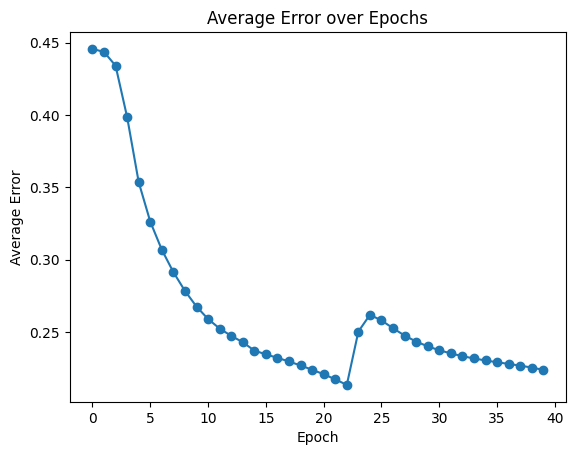

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(errors, marker='o',)
plt.xlabel('Epoch')
plt.ylabel('Average Error')
plt.title('Average Error over Epochs')
plt.show()
